# Base Characteristics

In [1]:
# Graph: Distribution of engine lifespans (histogram)

def plot_engine_lifespan_hist(df, dataset_name="FD001", bins=20, savepath=None, ax=None):
    """
    Plot a histogram of engine lifespans (max cycles per unit) using the
    C-MAPSS column names: 'unit_number' and 'time_in_cycles'.

    Args:
        df (pd.DataFrame): Raw or preprocessed dataset with required columns.
        dataset_name (str): Label used in the plot title.
        bins (int): Number of histogram bins.
        savepath (str | Path | None): If provided, saves the figure.
        ax (matplotlib.axes.Axes | None): Optional axes to draw on.

    Returns:
        pd.Series: Lifespan (max cycles) per engine, indexed by unit_number.
    """
    required_cols = {"unit_number", "time_in_cycles"}
    missing = required_cols - set(df.columns)
    if missing:
        raise KeyError(f"Missing columns {missing}. Expected {required_cols}.")

    # Compute lifespan per engine (max cycles before failure)
    lifespans = df.groupby("unit_number")["time_in_cycles"].max().sort_values()

    # Prepare axes
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        created_fig = True

    # Plot histogram
    ax.hist(lifespans, bins=bins, edgecolor="black")
    ax.set_title(f"Distribution of Engine Lifespans ({dataset_name})")
    ax.set_xlabel("Max Cycles Before Failure")
    ax.set_ylabel("Number of Engines")
    ax.grid(True, linestyle="--", alpha=0.5)

    # Annotate mean ± std for quick reference
    mean_cycles = lifespans.mean()
    std_cycles = lifespans.std()
    ax.axvline(mean_cycles, linestyle="--", linewidth=1)
    ax.text(mean_cycles, ax.get_ylim()[1] * 0.95,
            f"mean={mean_cycles:.1f}\nσ={std_cycles:.1f}",
            ha="center", va="top")

    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")

    if created_fig:
        plt.tight_layout()
        plt.show()

    return lifespans

#================================================================================================================

# Graph: example rul trajectories
from typing import Iterable, Dict, List, Optional, Tuple

def plot_example_rul_trajectories(df, unit_ids, max_rul=130,
                                   dataset_name="FD001", savepath=None):
    """Line plots of RUL vs cycles for selected engines."""
    import matplotlib.pyplot as plt
    import pre_processing as pp

    df = df.copy()
    df = pp.calculate_rul(df, max_rul=max_rul)
    plt.figure(figsize=(10, 6))

    for uid in unit_ids:
        g = df[df.unit_number == uid].sort_values('time_in_cycles')
        plt.plot(g['time_in_cycles'], g['RUL'],
                 marker='.', linewidth=1, label=f"Engine {uid}")

    plt.title(f"Example RUL Trajectories ({dataset_name})")
    plt.xlabel("Cycle")
    plt.ylabel("RUL")
    plt.legend(ncol=2, fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    
#====================================================================================================================

# Graph: Sensor correlation heatmap
def plot_sensor_correlation_heatmap(df, dataset_name="FD001", method="pearson", savepath=None):
    """
    Plot a correlation heatmap for C-MAPSS sensor columns (sensor_measurement_*).

    Args:
        df (pd.DataFrame): DataFrame with sensor columns.
        dataset_name (str): Label for the title.
        method (str): Correlation method ('pearson', 'spearman', 'kendall').
        savepath (str|Path|None): If provided, save the figure.

    Returns:
        pd.DataFrame: Correlation matrix used for the plot.
    """
    import matplotlib.pyplot as plt

    sensor_cols = [c for c in df.columns if c.startswith("sensor_measurement")]
    if not sensor_cols:
        raise ValueError("No sensor_measurement_* columns found.")

    corr = df[sensor_cols].corr(method=method)

    # Prefer seaborn if available, else matplotlib fallback
    try:
        import seaborn as sns
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, cmap="coolwarm", center=0, square=True,
                    linewidths=0.5, cbar_kws={"shrink": 0.8})
    except Exception:
        plt.figure(figsize=(12, 10))
        im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        labels = [s.replace("sensor_measurement_", "S") for s in sensor_cols]
        plt.xticks(range(len(sensor_cols)), labels, rotation=90)
        plt.yticks(range(len(sensor_cols)), labels)

    plt.title(f"Sensor Correlation Heatmap ({dataset_name})")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

    return corr

#======================================================================================================================

import numpy as np
import pandas as pd

def summarize_sensor_correlations(df, method="pearson", top_k=5):
    """
    Summarize inter-sensor correlations and list top +/- pairs.

    Returns:
        stats (dict): mean/median of corr and |corr| over unique pairs
        top_pos (pd.DataFrame): top-k most positively correlated pairs
        top_neg (pd.DataFrame): top-k most negatively correlated pairs
        corr (pd.DataFrame): full correlation matrix for reuse
    """
    sensor_cols = [c for c in df.columns if c.startswith("sensor_measurement")]
    if len(sensor_cols) < 2:
        raise ValueError("Need at least two sensor_measurement_* columns.")

    corr = df[sensor_cols].corr(method=method)

    # take upper triangle (unique pairs, exclude diagonal)
    iu = np.triu_indices_from(corr, k=1)
    pair_list = []
    for i, j in zip(iu[0], iu[1]):
        pair_list.append({
            "sensor_a": sensor_cols[i],
            "sensor_b": sensor_cols[j],
            "corr": corr.iloc[i, j],
            "abs_corr": abs(corr.iloc[i, j]),
        })
    pairs = pd.DataFrame(pair_list)

    # summary stats
    stats = {
        "mean_corr": float(pairs["corr"].mean()),
        "median_corr": float(pairs["corr"].median()),
        "mean_abs_corr": float(pairs["abs_corr"].mean()),
        "median_abs_corr": float(pairs["abs_corr"].median()),
        "n_pairs": int(len(pairs)),
    }

    # top-k lists
    top_pos = pairs.sort_values("corr", ascending=False).head(top_k).reset_index(drop=True)
    top_neg = pairs.sort_values("corr", ascending=True ).head(top_k).reset_index(drop=True)

    return stats, top_pos, top_neg, corr


In [2]:
# Load Dataset


# Standard libs
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import joblib


# Project modules
import data_loader as dl
import pre_processing as pp
import evaluator as ev
import base_model as base
import lstm_model as lstm
import cnn_model as cnn
import cnn_lstm_model as cnnlstm

# ---- Paths ----
ROOT = Path.cwd()
CMAPS = ROOT / "CMaps"  # keep correct folder case
# ==== Minimal config you tweak next time ====
DATASET = "FD003"       # <— change this to FD002/FD003/FD004 later
SEQ_LEN = 30            # sliding window
MAX_RUL = 130           # RUL clipping
VAL_SPLIT = 0.30        # val split by unit

# Files derived from DATASET (so you edit one line only)
TRAIN_PATH = CMAPS / f"train_{DATASET}.txt"
TEST_PATH  = CMAPS / f"test_{DATASET}.txt"
RUL_PATH   = CMAPS / f"RUL_{DATASET}.txt"

# Artifacts folder for this dataset
ART_DIR = ROOT / f"{DATASET} data & artefacts"
ART_DIR.mkdir(exist_ok=True)

print(f"backend: torch | dataset: {DATASET}")
print("Train:", TRAIN_PATH.name, "| Test:", TEST_PATH.name, "| RUL:", RUL_PATH.name)


# --- Load FD001 ---
train_df = dl.load_raw_data(CMAPS / f"train_{DATASET}.txt")
test_df, rul_df = dl.load_test_data(
    CMAPS / f"test_{DATASET}.txt",
    CMAPS / f"RUL_{DATASET}.txt"
)

print("Loaded.")
print("  train_df:", train_df.shape, "  test_df:", test_df.shape, "  rul_df:", rul_df.shape)
assert train_df.shape[1] == 26 and test_df.shape[1] == 26

backend: torch | dataset: FD003
Train: train_FD003.txt | Test: test_FD003.txt | RUL: RUL_FD003.txt
Loaded.
  train_df: (24720, 26)   test_df: (16596, 26)   rul_df: (100, 1)


# Preamble

In [3]:
dl.inspect_data(train_df)

Shape: (24720, 26)

Unique engines: 100

Missing values:
 0

Max cycles per engine:
count    100.00000
mean     247.20000
std       86.48384
min      145.00000
25%      189.75000
50%      220.50000
75%      279.75000
max      525.00000
Name: time_in_cycles, dtype: float64

First 5 rows:


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


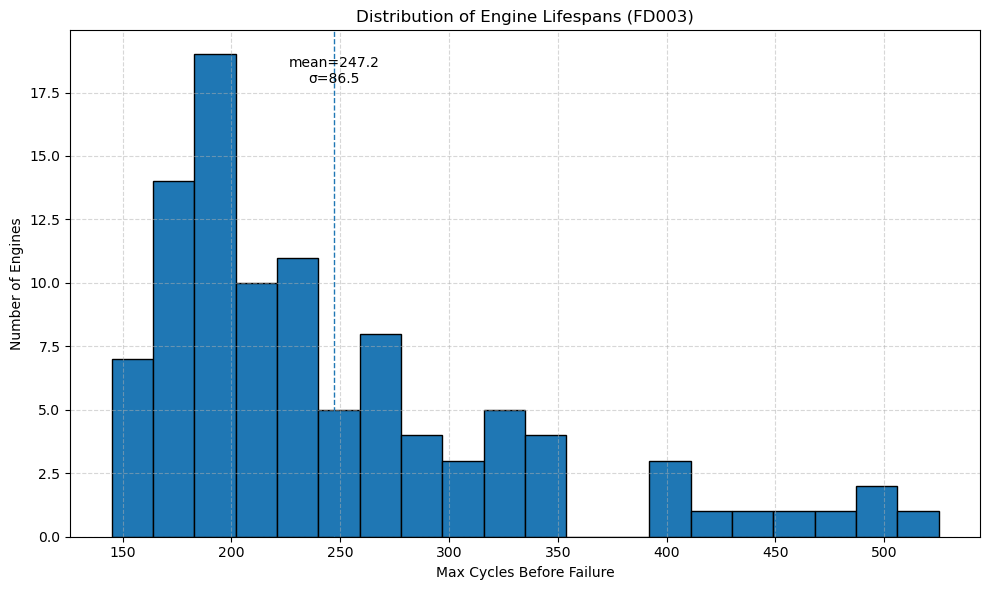

unit_number
99     145
80     147
100    152
76     153
91     156
      ... 
34     459
10     481
96     491
24     494
55     525
Name: time_in_cycles, Length: 100, dtype: int64

In [4]:
plot_engine_lifespan_hist(train_df, dataset_name=DATASET)

In [5]:
import numpy as np

def select_representative_units(df, random_state=42):
    """
    Select representative engine units:
    - Shortest-lived
    - Median-lived
    - Longest-lived
    - One random unit (reproducible with random_state)

    Args:
        df (pd.DataFrame): Engine dataset with 'unit_number' and 'time_in_cycles'.
        random_state (int): Seed for reproducibility.

    Returns:
        list[int]: List of selected engine IDs.
    """
    # Compute max cycles per engine
    lifespans = df.groupby("unit_number")["time_in_cycles"].max().sort_values()

    # Shortest-lived
    shortest = lifespans.index[0]
    # Median-lived
    median = lifespans.index[len(lifespans) // 2]
    # Longest-lived
    longest = lifespans.index[-1]
    # One random
    rng = np.random.default_rng(random_state)
    random_unit = rng.choice(lifespans.index)

    return [shortest, median, longest, int(random_unit)]


Selected engines: [99, 78, 55, 66]


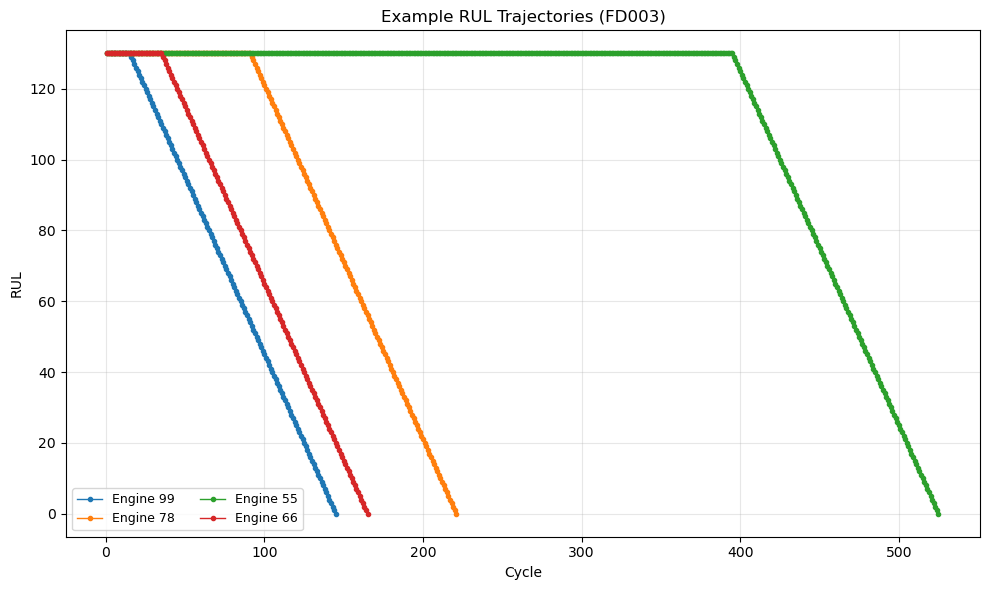

In [6]:
example_units = select_representative_units(train_df, random_state=42)
print("Selected engines:", example_units)

plot_example_rul_trajectories(train_df, unit_ids=example_units,
                              max_rul=MAX_RUL, dataset_name=DATASET)


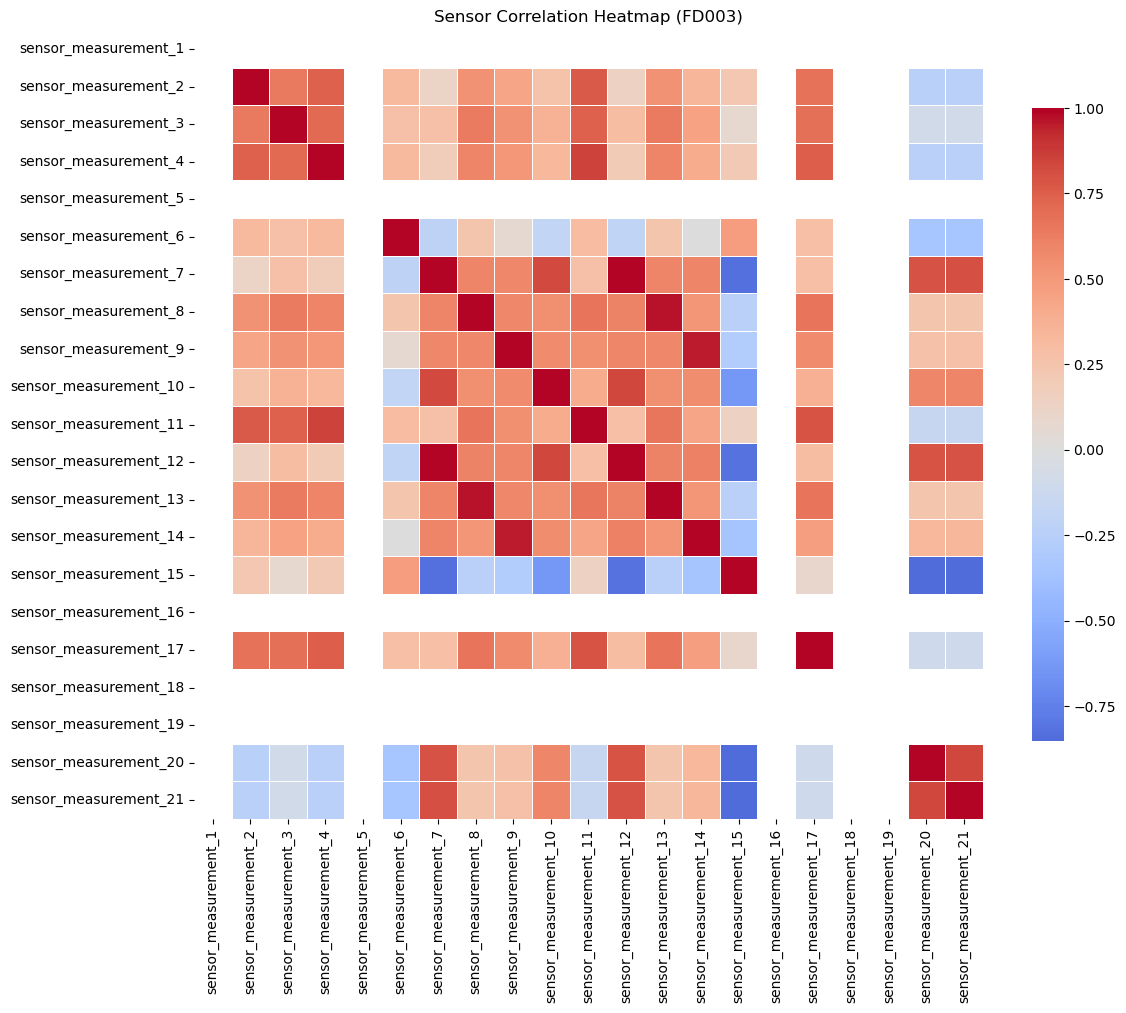

,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
sensor_measurement_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sensor_measurement_2,NaN,1.000000,0.640503,0.745167,NaN,0.314799,0.124167,0.533915,0.441283,0.256388,...,0.141785,0.532745,0.343954,0.232947,NaN,0.670062,NaN,NaN,-0.246286,-0.241318
sensor_measurement_3,NaN,0.640503,1.000000,0.716890,NaN,0.269463,0.282007,0.637926,0.535074,0.367705,...,0.298941,0.636513,0.454205,0.076820,NaN,0.677216,NaN,NaN,-0.091851,-0.089035
sensor_measurement_4,NaN,0.745167,0.716890,1.000000,NaN,0.319139,0.181976,0.601272,0.509782,0.330834,...,0.202106,0.601254,0.404686,0.216773,NaN,0.749907,NaN,NaN,-0.235016,-0.230134
sensor_measurement_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sensor_measurement_6,NaN,0.314799,0.269463,0.319139,NaN,1.000000,-0.208690,0.247480,0.065131,-0.184268,...,-0.200906,0.247099,0.008579,0.485677,NaN,0.285658,NaN,NaN,-0.345912,-0.347739
sensor_measurement_7,NaN,0.124167,0.282007,0.181976,NaN,-0.208690,1.000000,0.596510,0.579004,0.830550,...,0.988725,0.597169,0.601013,-0.826574,NaN,0.285796,NaN,NaN,0.802838,0.807138
sensor_measurement_8,NaN,0.533915,0.637926,0.601272,NaN,0.247480,0.596510,1.000000,0.578587,0.547105,...,0.608298,0.964052,0.519624,-0.238368,NaN,0.662618,NaN,NaN,0.241726,0.244548
sensor_measurement_9,NaN,0.441283,0.535074,0.509782,NaN,0.065131,0.579004,0.578587,1.000000,0.560163,...,0.590891,0.578325,0.954354,-0.287941,NaN,0.559109,NaN,NaN,0.263300,0.271765
sensor_measurement_10,NaN,0.256388,0.367705,0.330834,NaN,-0.184268,0.830550,0.547105,0.560163,1.000000,...,0.836185,0.547460,0.555604,-0.631628,NaN,0.377688,NaN,NaN,0.592349,0.600931


In [7]:
plot_sensor_correlation_heatmap(train_df, dataset_name=DATASET)

In [8]:
stats, top_pos, top_neg, corr = summarize_sensor_correlations(train_df, method="pearson", top_k=5)

print("Correlation summary:", {k: round(v, 3) if isinstance(v, float) else v for k, v in stats.items()})

display(top_pos.round(3))
display(top_neg.round(3))

Correlation summary: {'mean_corr': 0.323, 'median_corr': 0.373, 'mean_abs_corr': 0.458, 'median_abs_corr': 0.448, 'n_pairs': 210}


,sensor_a,sensor_b,corr,abs_corr
0,sensor_measurement_7,sensor_measurement_12,0.989,0.989
1,sensor_measurement_8,sensor_measurement_13,0.964,0.964
2,sensor_measurement_9,sensor_measurement_14,0.954,0.954
3,sensor_measurement_4,sensor_measurement_11,0.854,0.854
4,sensor_measurement_20,sensor_measurement_21,0.839,0.839


,sensor_a,sensor_b,corr,abs_corr
0,sensor_measurement_15,sensor_measurement_21,-0.852,0.852
1,sensor_measurement_15,sensor_measurement_20,-0.850,0.850
2,sensor_measurement_7,sensor_measurement_15,-0.827,0.827
3,sensor_measurement_12,sensor_measurement_15,-0.820,0.820
4,sensor_measurement_10,sensor_measurement_15,-0.632,0.632


In [9]:
train__clean = pp.drop_flat_sensors(train_df.copy())

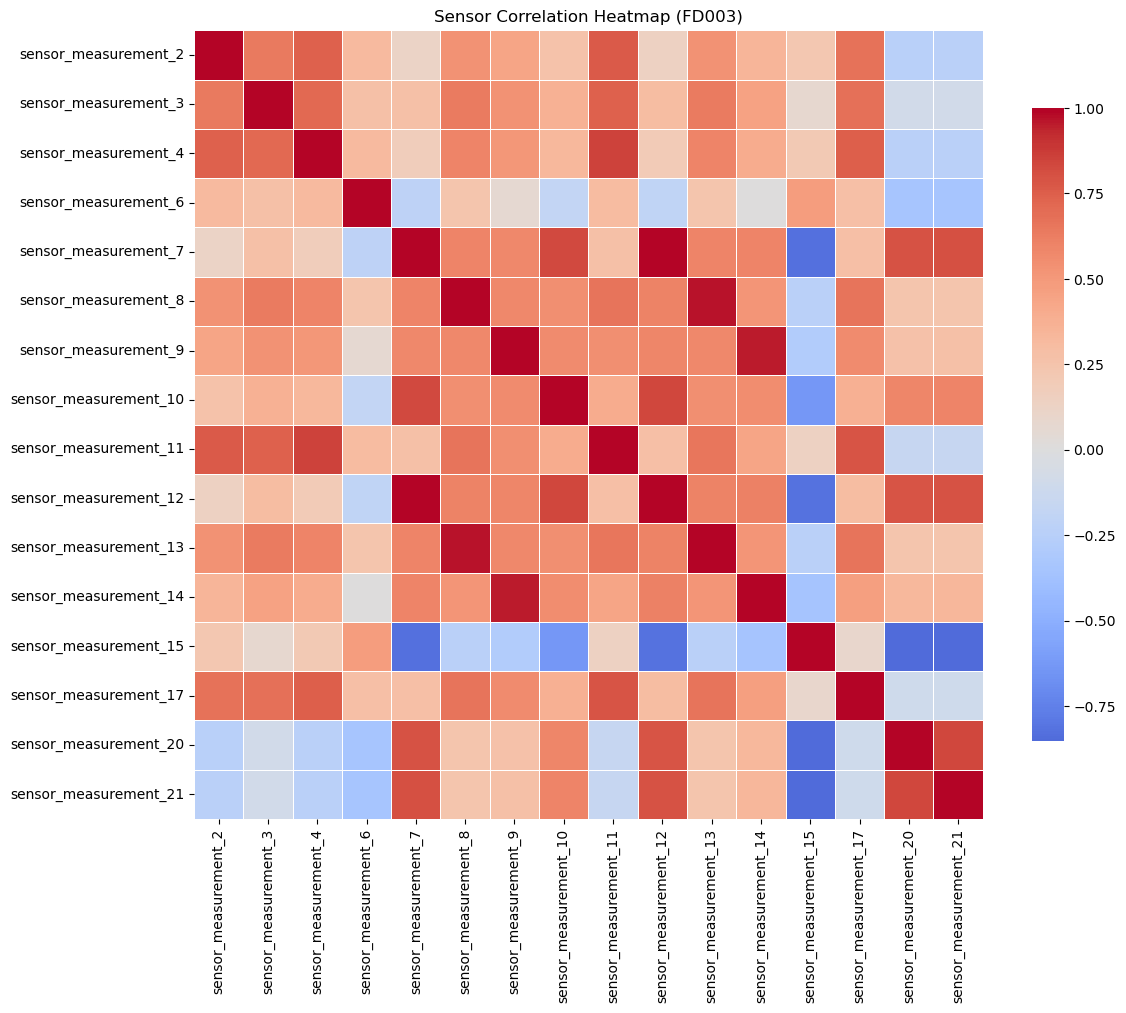

,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21
sensor_measurement_2,1.000000,0.640503,0.745167,0.314799,0.124167,0.533915,0.441283,0.256388,0.762269,0.141785,0.532745,0.343954,0.232947,0.670062,-0.246286,-0.241318
sensor_measurement_3,0.640503,1.000000,0.716890,0.269463,0.282007,0.637926,0.535074,0.367705,0.746093,0.298941,0.636513,0.454205,0.076820,0.677216,-0.091851,-0.089035
sensor_measurement_4,0.745167,0.716890,1.000000,0.319139,0.181976,0.601272,0.509782,0.330834,0.854030,0.202106,0.601254,0.404686,0.216773,0.749907,-0.235016,-0.230134
sensor_measurement_6,0.314799,0.269463,0.319139,1.000000,-0.208690,0.247480,0.065131,-0.184268,0.305777,-0.200906,0.247099,0.008579,0.485677,0.285658,-0.345912,-0.347739
sensor_measurement_7,0.124167,0.282007,0.181976,-0.208690,1.000000,0.596510,0.579004,0.830550,0.270774,0.988725,0.597169,0.601013,-0.826574,0.285796,0.802838,0.807138
sensor_measurement_8,0.533915,0.637926,0.601272,0.247480,0.596510,1.000000,0.578587,0.547105,0.660209,0.608298,0.964052,0.519624,-0.238368,0.662618,0.241726,0.244548
sensor_measurement_9,0.441283,0.535074,0.509782,0.065131,0.579004,0.578587,1.000000,0.560163,0.546839,0.590891,0.578325,0.954354,-0.287941,0.559109,0.263300,0.271765
sensor_measurement_10,0.256388,0.367705,0.330834,-0.184268,0.830550,0.547105,0.560163,1.000000,0.405592,0.836185,0.547460,0.555604,-0.631628,0.377688,0.592349,0.600931
sensor_measurement_11,0.762269,0.746093,0.854030,0.305777,0.270774,0.660209,0.546839,0.405592,1.000000,0.290664,0.659375,0.441050,0.144079,0.783722,-0.163929,-0.159264
sensor_measurement_12,0.141785,0.298941,0.202106,-0.200906,0.988725,0.608298,0.590891,0.836185,0.290664,1.000000,0.608714,0.610383,-0.819711,0.303758,0.794781,0.800166


In [10]:
plot_sensor_correlation_heatmap(train__clean, dataset_name=DATASET)

In [11]:
stats, top_pos, top_neg, corr = summarize_sensor_correlations(train__clean, method="pearson", top_k=5)

print("Correlation summary:", {k: round(v, 3) if isinstance(v, float) else v for k, v in stats.items()})

display(top_pos.round(3))
display(top_neg.round(3))

Correlation summary: {'mean_corr': 0.323, 'median_corr': 0.373, 'mean_abs_corr': 0.458, 'median_abs_corr': 0.448, 'n_pairs': 120}


,sensor_a,sensor_b,corr,abs_corr
0,sensor_measurement_7,sensor_measurement_12,0.989,0.989
1,sensor_measurement_8,sensor_measurement_13,0.964,0.964
2,sensor_measurement_9,sensor_measurement_14,0.954,0.954
3,sensor_measurement_4,sensor_measurement_11,0.854,0.854
4,sensor_measurement_20,sensor_measurement_21,0.839,0.839


,sensor_a,sensor_b,corr,abs_corr
0,sensor_measurement_15,sensor_measurement_21,-0.852,0.852
1,sensor_measurement_15,sensor_measurement_20,-0.850,0.850
2,sensor_measurement_7,sensor_measurement_15,-0.827,0.827
3,sensor_measurement_12,sensor_measurement_15,-0.820,0.820
4,sensor_measurement_10,sensor_measurement_15,-0.632,0.632
